# Multi-class Classification on Mendeley Liquid Based Cythology Dataset

Train and test in Google Colaboratory.  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1izj-sGomUxZYb2QGGSnKGdVqfeInbmJP?usp=sharing)

## Install & Import Dependencies

In [1]:
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob2 import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import io, models, transforms, utils
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tqdm

## Download & Prepare Dataset

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zddtpgzv63-4.zip
!unzip -o zddtpgzv63-4.zip -d cevical
!rm -f zddtpgzv63-4.zip

In [4]:
HSIL = pd.DataFrame({
    "IMAGES": glob("cevical/High squamous intra-epithelial lesion/*.jpg"),
    "LABELS": 0
})

LSIL = pd.DataFrame({
    "IMAGES": glob("cevical/Low squamous intra-epithelial lesion/*.jpg"),
    "LABELS": 1
})

NILM = pd.DataFrame({
    "IMAGES": glob("cevical/Negative for Intraepithelial malignancy/*.jpg"),
    "LABELS": 2
})

SCC = pd.DataFrame({
    "IMAGES": glob("cevical/Squamous cell carcinoma/*.jpg"),
    "LABELS": 3
})

In [5]:
pd_dataset = pd.concat([HSIL, LSIL, NILM, SCC], axis=0)
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,LABELS
0,cevical/Negative for Intraepithelial malignanc...,2
1,cevical/Negative for Intraepithelial malignanc...,2
2,cevical/Low squamous intra-epithelial lesion/L...,1
3,cevical/High squamous intra-epithelial lesion/...,0
4,cevical/Negative for Intraepithelial malignanc...,2


In [6]:
pd_dataset['LABELS'].value_counts()

2    612
0    163
1    113
3     74
Name: LABELS, dtype: int64

In [7]:
pd_train, pd_test = train_test_split(pd_dataset, test_size=0.2, random_state=0)
pd_val, pd_test = train_test_split(pd_test, test_size=0.5, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 769
Validation set size: 96
Testing set size: 97


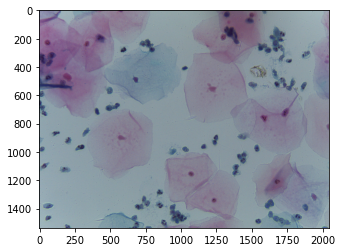

In [8]:
sample = io.read_image(pd_train.iloc[122].IMAGES)
plt.imshow(sample.permute(1,2,0).squeeze(), cmap='gray')

## Define Global Parameters




In [9]:
IMAGE_SIZE = 560
BATCH_SIZE = 16
EPOCHS = 50
CLASSES = ["HSIL", "LSIL", "NILM", "SCC"]

In [10]:
!nvidia-smi

Sat Aug 27 11:59:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Augmentation & Transformation

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter()
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
])

## Create PyTorch Dataset

In [12]:
class CervicalDataset(Dataset):
    def __init__(self, df, transformations):
        self.df = df
        self.transformations = transformations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = io.read_image(row.IMAGES).float()
        image = self.transformations(image)
        image = image / 255.0

        return image, row.LABELS

In [13]:
class CervicalDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = CervicalDataset(self.pd_train, train_transform)
        self.val_dataset = CervicalDataset(self.pd_val, test_transform)
        self.test_dataset = CervicalDataset(self.pd_test, test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)


In [14]:
data_module = CervicalDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

Ground Truth:  NILM


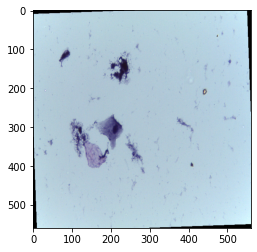

In [15]:
image, label = next(iter(data_module.train_dataloader()))
plt.imshow(image[15].permute(1,2,0).squeeze(), cmap='gray')
print("Ground Truth: ", CLASSES[label[15]])

## Model and Training Classes

In [16]:
model = models.resnet50()

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(CLASSES))

In [17]:
class CervicalClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=4, average='macro')
        self.precise= Precision(num_classes=4, average="weighted")
        self.recall = Recall(num_classes=4, average="weighted")
        self.f1score = F1Score(num_classes=4, average="weighted")
    
    def forward(self, x, labels=None):
        outputs = self.model(x)
        if labels is not None:
            loss = self.criterion(outputs, labels)
            metrics = {
                "accuracy": self.accuracy(outputs, labels),
                "precision": self.precise(outputs, labels),
                "recall": self.recall(outputs, labels),
                "f1score": self.f1score(outputs, labels)
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, labels = batch

        loss, metrics, outputs = self(images, labels)
        self.log("train/loss", loss, prog_bar=True, logger=True)
        self.log_dict({
            "train/accuracy": metrics['accuracy'],
            "train/precision": metrics['precision'],
            "train/recall": metrics['recall'],
            "train/f1score": metrics['f1score']
        }, prog_bar=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch

        loss, metrics, outputs = self(images, labels)
        self.log("val/loss", loss, prog_bar=True, logger=True)
        self.log_dict({
            "val/accuracy": metrics['accuracy'],
            "val/precision": metrics['precision'],
            "val/recall": metrics['recall'],
            "val/f1score": metrics['f1score']
        }, prog_bar=False, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch

        loss, metrics, outputs = self(images, labels)
        self.log("test/loss", loss, prog_bar=True, logger=True)
        self.log_dict({
            "test/accuracy": metrics['accuracy'],
            "test/precision": metrics['precision'],
            "test/recall": metrics['recall'],
            "test/f1score": metrics['f1score']
        }, prog_bar=False, logger=True)
        return loss

In [18]:
CervicalModel = CervicalClassifier()
summary(CervicalModel, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
CervicalClassifier                            [16, 4]                   --
├─ResNet: 1-1                                 [16, 4]                   14,972,932
│    └─Conv2d: 2-1                            [16, 64, 280, 280]        9,408
│    └─BatchNorm2d: 2-2                       [16, 64, 280, 280]        128
│    └─ReLU: 2-3                              [16, 64, 280, 280]        --
│    └─MaxPool2d: 2-4                         [16, 64, 140, 140]        --
│    └─Sequential: 2-5                        [16, 256, 140, 140]       --
│    │    └─Bottleneck: 3-1                   [16, 256, 140, 140]       75,008
│    │    └─Bottleneck: 3-2                   [16, 256, 140, 140]       70,400
│    │    └─Bottleneck: 3-3                   [16, 256, 140, 140]       70,400
│    └─Sequential: 2-6                        [16, 512, 70, 70]         --
│    │    └─Bottleneck: 3-4                   [16, 512, 70, 70]        

## Training

In [19]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/loss",
    mode="min"
)


logger = CSVLogger("lightning_logs", name="cervical-cancer-identifier")

early_stopping_callback = EarlyStopping(monitor="val/loss", patience=5)

trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    gpus=1
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:453: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(CervicalModel, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23.5 M
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     
3 | precise   | Precision        | 0     
4 | recall    | Recall           | 0     
5 | f1score   | F1Score          | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1902: PossibleUserWarning: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Testing

In [21]:
trainer.test(CervicalModel, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9438716173171997     │
│       test/f1score        │    0.9527491927146912     │
│         test/loss         │    0.10391878336668015    │
│      test/precision       │    0.9670103192329407     │
│        test/recall        │    0.9587628841400146     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.10391878336668015,
  'test/accuracy': 0.9438716173171997,
  'test/precision': 0.9670103192329407,
  'test/recall': 0.9587628841400146,
  'test/f1score': 0.9527491927146912}]

## Inference

In [22]:
infer_model = CervicalModel.load_from_checkpoint("lightning_logs/cervical-cancer-identifier/version_0/checkpoints/epoch=6-step=343.ckpt")

In [23]:
prediction = infer_model(image[0].unsqueeze(0))
prediction = torch.nn.Softmax()(prediction)
prediction = torch.argmax(prediction)
CLASSES[prediction]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


'NILM'